In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
#change directory to the folder where the images are stored on google drive
%cd /content/drive/MyDrive/MLPR - Y4T3/Datasets

/content/drive/MyDrive/MLPR - Y4T3/Datasets


In [56]:
#check the current directory
!pwd

/content/drive/MyDrive/MLPR - Y4T3/Datasets


In [57]:
!pip install keras

In [58]:
from tensorflow.keras.layers import Input, Lambda, Dense,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, Conv2D,MaxPool2D
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [59]:
train_path="cat-dog-dataset/train"
test_path="cat-dog-dataset/test"
val_path="cat-dog-dataset/val"

In [60]:
import os
import cv2
x_train=[]
for folder in os.listdir(train_path):
  sub_path=train_path+"/"+folder
  for img in os.listdir(sub_path):
    image_path=sub_path+"/"+img
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224, 224))
    x_train.append(img_arr)

In [61]:
image_path

'cat-dog-dataset/train/cat/cat.1295.jpg'

In [62]:
x_test=[]
for folder in os.listdir(test_path):
  sub_path=test_path+"/"+folder
  for img in os.listdir(sub_path):
    image_path=sub_path+"/"+img
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224, 224))
    x_test.append(img_arr)

In [63]:
x_val=[]
for folder in os.listdir(val_path):
  sub_path=val_path+"/"+folder
  for img in os.listdir(sub_path):
    image_path=sub_path+"/"+img
    img_arr=cv2.imread(image_path)
    img_arr=cv2.resize(img_arr,(224, 224))
    x_val.append(img_arr)

In [64]:
# Import the NumPy module
import numpy as np
# Convert the lists into NumPy arrays
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

##Divide for normalization

In [65]:
#x_test, must be divided by 255.0 for normalization.
test_x=test_x/255.0

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [67]:
training_set = train_datagen.flow_from_directory(train_path,target_size = (224, 224), batch_size = 32, class_mode = 'sparse')

Found 5003 images belonging to 2 classes.


In [68]:
test_set = test_datagen.flow_from_directory(test_path, target_size = (224, 224), batch_size = 32, class_mode = 'sparse')

Found 1600 images belonging to 2 classes.


In [69]:
val_set = val_datagen.flow_from_directory(val_path, target_size = (224, 224), batch_size = 32, class_mode = 'sparse')

Found 400 images belonging to 2 classes.


In [70]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [71]:
training_set.class_indices
train_y.shape,test_y.shape,val_y.shape

((5003,), (1600,), (400,))

In [72]:
labels = {value: key for key, value in
training_set.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
  print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : cat
1 : dog


View some sample training images

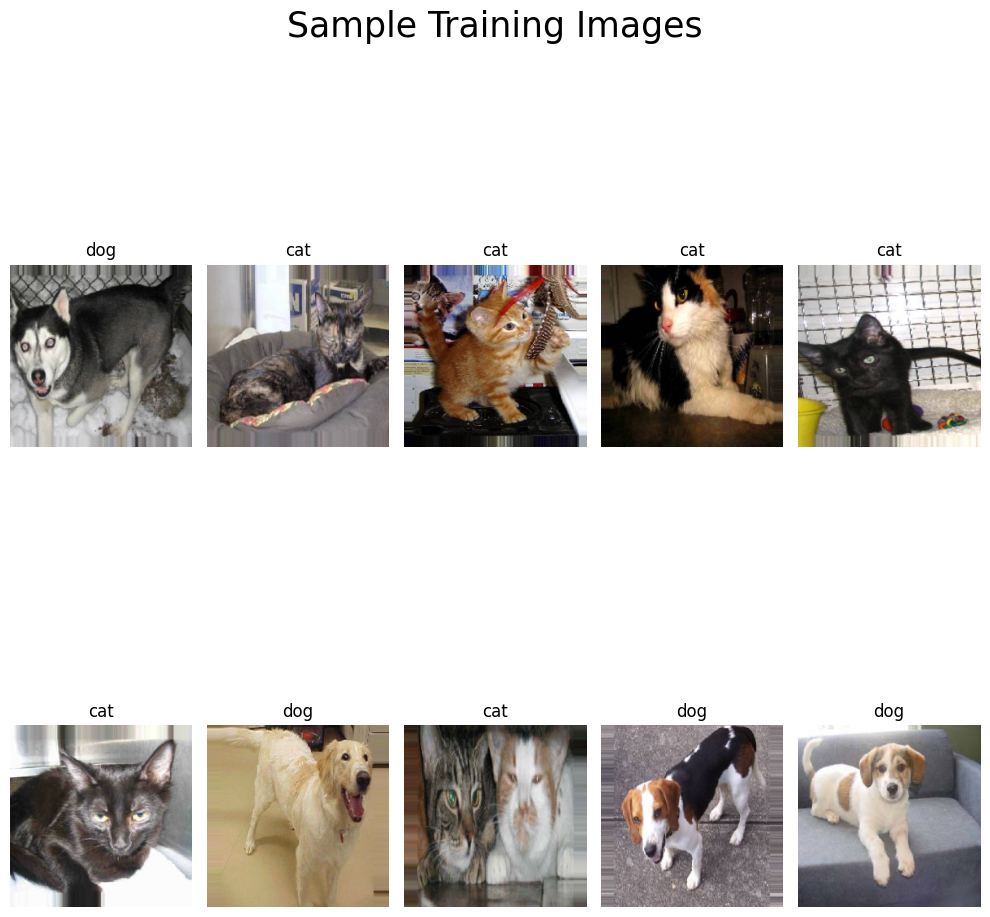

In [73]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 12))
idx = 0
for i in range(2):
  for j in range(5):
    #label = labels[np.argmax(training_set[0][1][idx])]
    label = labels[training_set[0][1][idx]]
    ax[i, j].set_title(f"{label}")
    ax[i, j].imshow(training_set[0][0][idx][:, :, :])
    ax[i, j].axis("off")
    idx += 1
plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=25)
plt.show()

Build the model

In [74]:
from tensorflow.keras.applications import VGG19
vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
  layer.trainable = False

Customize the model - change the last layer

In [75]:
from tensorflow.keras.layers import Flatten
x = Flatten()(vgg.output)

In [76]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [77]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [78]:
model.compile( loss='sparse_categorical_crossentropy',
optimizer="adam",
metrics=['accuracy']
)

In [79]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
early_stopping_monitor = EarlyStopping(monitor='val_loss', mode='min',
verbose=1, patience=5)
#Early stopping to avoid overfitting of model

In [80]:
model_file = 'best_vgg_model.keras'

In [81]:
model_check_point = ModelCheckpoint(model_file, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [82]:
# fit the model
history = model.fit(
training_set,
validation_data=val_set ,
epochs=3,
callbacks=[early_stopping_monitor, model_check_point],
batch_size=32,shuffle=True)

Epoch 1/3
157/157 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8305
Epoch 1: val_loss improved from inf to 0.67929, saving model to best_vgg_model.keras
157/157 [==============================] - 91s 569ms/step - loss: 0.3796 - accuracy: 0.8305 - val_loss: 0.6793 - val_accuracy: 0.7275
Epoch 2/3
157/157 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8897
Epoch 2: val_loss improved from 0.67929 to 0.21489, saving model to best_vgg_model.keras
157/157 [==============================] - 87s 555ms/step - loss: 0.2682 - accuracy: 0.8897 - val_loss: 0.2149 - val_accuracy: 0.9050
Epoch 3/3
157/157 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9067
Epoch 3: val_loss did not improve from 0.21489
157/157 [==============================] - 87s 556ms/step - loss: 0.2170 - accuracy: 0.9067 - val_loss: 0.2865 - val_accuracy: 0.8875


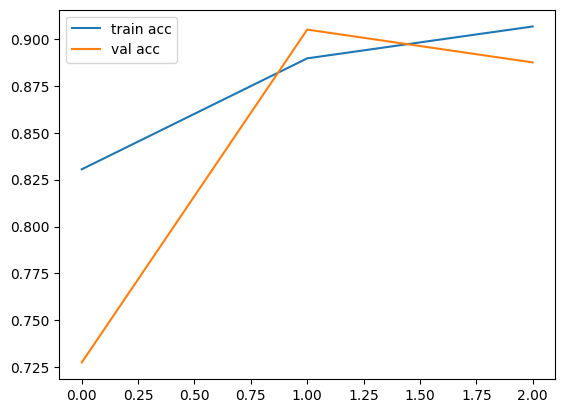

In [83]:
# Import the necessary modules
import matplotlib.pyplot as plt
# Plot the accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

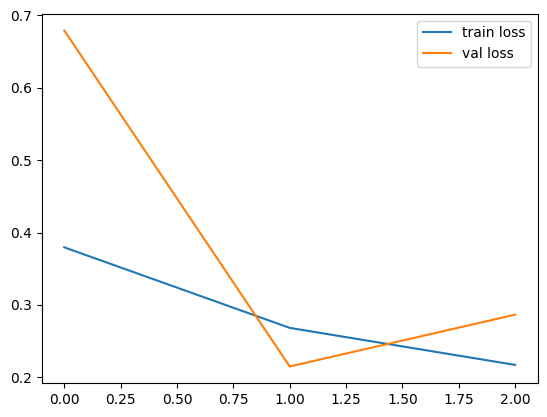

In [84]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [85]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/MLPR - Y4T3/Datasets/best_vgg_model.keras')

In [86]:
# Evaluate the model on the test data
model.evaluate(test_set, batch_size=32)

50/50 [==============================] - 10s 184ms/step - loss: 0.2481 - accuracy: 0.8925


[0.2480597048997879, 0.8924999833106995]

In [87]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred, test_y))

#get confusion matrix
print(confusion_matrix(y_pred,test_y))

50/50 [==============================] - 9s 174ms/step
              precision    recall  f1-score   support

           0       0.06      0.07      0.07       730
           1       0.15      0.14      0.14       870

    accuracy                           0.11      1600
   macro avg       0.11      0.10      0.11      1600
weighted avg       0.11      0.11      0.11      1600

[[ 51 679]
 [749 121]]


In [88]:
predictions = model.predict(test_x)

50/50 [==============================] - 8s 171ms/step


In [89]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(24, 20))
idx = 10
for i in range(2):
  for j in range(6):
    predicted_label = labels[np.argmax(predictions[idx])]
    ax[i, j].set_title(f"{predicted_label}")
    ax[i, j].imshow(test_x[idx])
    ax[i, j].axis("off")
    idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

Output hidden; open in https://colab.research.google.com to view.